# Introduction To Digital Signal Processing(DSP): Using Real Life Audio Signals and CuSignal For Processing

You are wondering how technology companies manage to make amazing audio systems with clean and clear sounds, well here is the foundation. Thankfully python has become the go-to language for getting started with programing, engineers are also taking advantage of the language for more advance uses. You can learn more about getting started with python [here](https://www.learnpython.org/). 

The main objective of this discussion is to apply basic DSP concepts to see how can we filter out noise from a music or audio recording. There are several applications and APIs that already do this with just function calls, but the aim of this discussion is to apply the basic concepts and introduce students or enthusiasts to DSP using a real world example and how things come together. There are obviously more efficient ways to go about this but that is not our aim for now. Future discussions will involve using machine learning to automatically detect noise and reproduce the desired music/sound. Another applicaton is in training a machine learning model to tell us where the aduio signal is coming from, maybe a hallway, party or an ocean front. I'll try not to inundate this notebook with DSP mathematical ewuati so even the non-engineers can follow. The Mathematics involved in DSP are 'FUN' but it is also nice to visualize these concepts as we learn. Follow closely and I hope you find it helpful.

This notebook will use [NVIDIA RAPIDS](https://rapids.ai/) APIs and libraries, they'll help us take advantage of the amazing GPU speeds and computing power. [cuSignal](https://github.com/rapidsai/cusignal) in particular is very similar to the popular Python [SciPy](https://scipy.org) API used in so many engineering and scientific computation. [CuPy](https://cupy.dev/) is also replacing the popular [NumPy](https://numpy.org/) API in this notebook to take advantage of the GPU processing power. 

Why GPU processing you ask, well in a case where real-time processing is required, the faster the better so why not? You can handle higher sample rates, amongst other advantages. Professors, researchers, students, industry experts can easily leverage existing compatible GPUs they have to use RAPIDS. You don't have a supported GPU to run these APIs and libraries? Don't worry the CPU version of this notebook is included in the repository. Enough of the talk, now let's get into it. 

The topics we will cover are:

* Time Domain Signals
* Frequency Domain Signals
* FFT (Fast Fourier Transform)
* Filters
* Convolution
* Spectogram

![Block.png](Blockdiagram.png)

Now we import our necessary libraries needed.

In [7]:
import cupy as cp
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
from scipy.io.wavfile import write
import cusignal

We chose the same audio length(i.e 3 minutes) to reduce complexity and manipulation steps required to achieve that. Both audio files were modified prior to uploading. The free .wav audio files were gotten from freesound.org

### Time Domain Signals

In [8]:
#Creating a function to extract our .wav sound files
def read_wav_file(file_name):
    sample_rate, audio_signal = wavfile.read(file_name)
    length = len(audio_signal)/sample_rate
    return audio_signal, sample_rate, length

music, sample_rate, length_m = read_wav_file('music.wav') #creating the music signal
noise, sample_rate, length_n = read_wav_file('noise.wav') #creating the noisy signal

# Define time vector for both music and noise, they are the same(180 secs)
time = cp.linspace(0., length_m, music.shape[0]) #len(music) also works

As we will see in the plots below, remember that your earphones for example have both right and left channels. This is the reason for plotting both channels below, our computation only needs one.

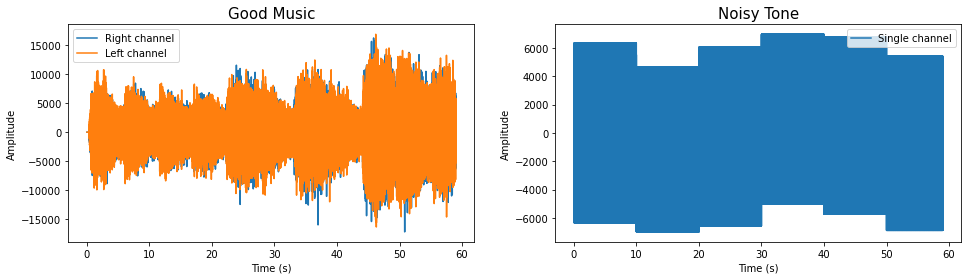

In [9]:
#Plotting both signals
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

[r_channel, l_channel] = ax1.plot(cp.asnumpy(time), cp.asnumpy(music))
ax1.legend([r_channel, l_channel], ['Right channel', 'Left channel'], loc=2)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Good Music', size=15)

[s_channel] = ax2.plot(cp.asnumpy(time), cp.asnumpy(noise))
ax2.legend([s_channel], ['Single channel'], loc=1)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Noisy Tone', size=15); # A semi-colon is added to the end of the plotting cell to suppress unwanted output(text)

We will now plot the same signals above but this time around, we will use a similar amplitude scale for both music and noise, this way you can see how low the noise amplitude is, compared to the music.

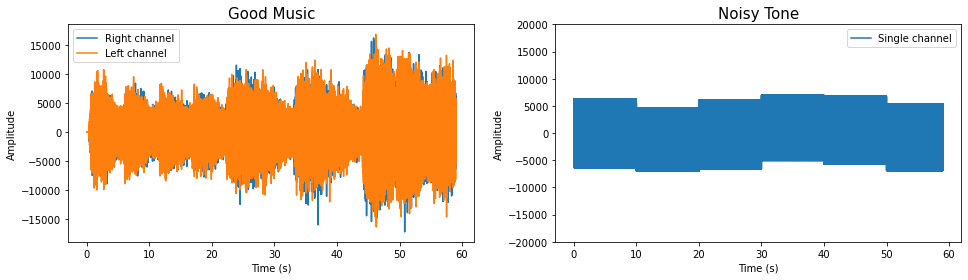

In [10]:
#Plotting both signals
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

[r_channel, l_channel] = ax1.plot(cp.asnumpy(time), cp.asnumpy(music))
ax1.legend([r_channel, l_channel], ['Right channel', 'Left channel'], loc=2)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Good Music', size=15)

[s_channel] = ax2.plot(cp.asnumpy(time), cp.asnumpy(noise))
ax2.legend([s_channel], ['Single channel'], loc=1)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Noisy Tone', size=15)
ax2.set_ylim(-20000,20000);

Now we will listen to the sound using a python library called `Audio`. This gives us a GUI to interact with and we will do this for all signals generated in this notebook.

In [ ]:
#pip install librosa

from IPython.display import Audio
play_music = Audio('music.wav')
play_music

As a backstory to the noisy signal you're about to listen to, the aplitude was reduced by `3 times`, since the original file we downloaded had an amplitude of over 25,000, higher than the music. Remember again, the amplitude is related to the loudness of a signal. Listen to the original sound here, please start at 5% volume and gradually increase the volume to reduce any hearing risk. Sound source is [here](https://freesound.org/people/KristopherTiberiusHaven/sounds/147034/) 

In [ ]:
play_noise = Audio('noise.wav')
play_noise

Next, we will combine both signals, remember the linearity property of a time domain signal 

$$
z(t) = x(t) + y(t)
$$

In this case, our output $z(t)$ is a combined signal(the music with the noise). Take note that multiplying two signals in time domain is completely different and has a different effect, we will look into that in later discussions. Now back to the main topic. 

In [11]:
#Creating the combined signal, we will listen to it in the next few cells

noisy_music = music[:,1] + noise

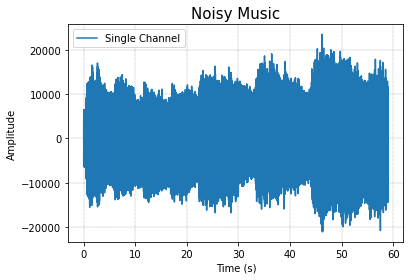

In [12]:
#Plotting the noisy music
plt.plot(cp.asnumpy(time), cp.asnumpy(noisy_music), label='Single Channel' )
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Noisy Music', size=15)
# plt.show()
plt.grid(True, color='k', linestyle=':', linewidth=0.3)

Take note that the plot above looks very similar to the music plot as well, this is because the noise has a lower amplitude than the music and it cannot be seen. We will listen to the sound and notice the difference to verify this.

Python lets us create our own .wav file using the `wavefile` library. Our noisy music has both right and left channels like we saw in the initial plots. We will write(save) the noisy music and play it back.

In [ ]:
#Creating a .wav file for the combined sound generated above
# from scipy.io.wavfile import write
write('noisy_music.wav', 44100, noisy_music)

#### *CAUTION!!! Start playing the `noisy_music.wav` at 10% speaker/headset volume and increase gradually to reduce hearing risk, this combined sound has the high pitch noise added*

In [ ]:
#Playing the sound we just created by adding both files
play_noisy_music = Audio('noisy_music.wav')
play_noisy_music

### Fast Fourier Transform (FFT)

After listening to the noisy music, we can hear the high pitch sound in the background. Our aim now will be to identify the frequency of this noise using FFT and apply a filter to remove the undesired signal(in this case, our noise). 

To give a brief overview of what FFT means. First, we need to note that a signal plotted in time domain looks entirely different in the frequency domain. In the imagee below, we can see what we mean. 

![FFT.png](FFT.png)

<!-- 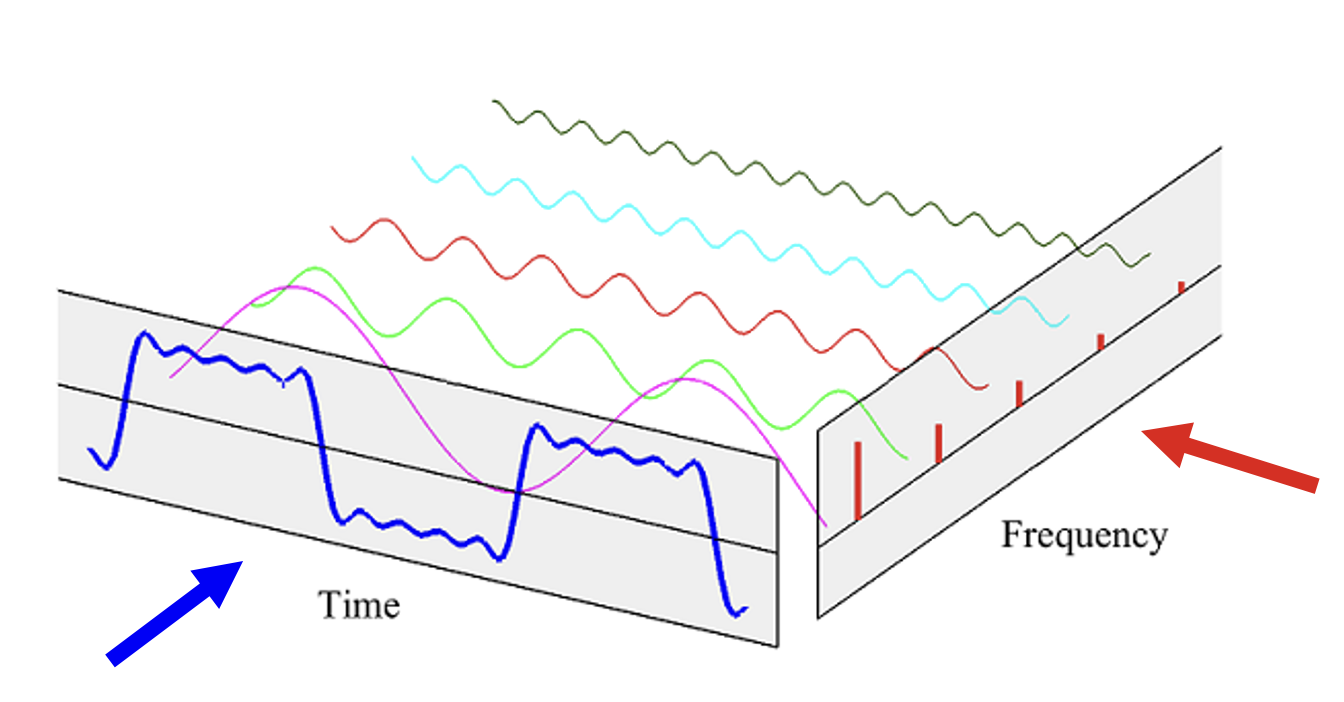 -->

The time domain is similar to all our plots earlier, you see a combination of various frequencies, which makes the time domain plot look 'noisy'. In our case, we do not know what frequencies are present in our signal and we need to find this out. We use frequency domain for numerous analysis and we will see why as we go further in the discussions. 

We will also use a spectogram later in the discussion to visualize both time and frequency domain with one plot. It is pretty interesting how much the spectrogram can be applied. Exciting discussions ahead!!!

In [13]:
#Converting our arrays to a cupy array
music = cp.asarray(music)
noise = cp.asarray(noise)
noisy_music = cp.asarray(noisy_music)

Usually we calculate the Power Spectra Density(PSD) but we will only use the magnitude here for simplicity, since our focus is on visualizing the frequency components of each signal for now. Focus less on the codes for now and look out for the outputs. There are several ways to go about this in Python but check the comments to find out how to calculate the PSD.

In [14]:
#STEP 1
#Creating the freqeuncy axis of our noisy music plot
n = noisy_music.shape[0]
freq1 = (sample_rate/2)*cp.linspace(0,1,int(n//2))

#Computng the FFT of our noisy music
noisy_music_fft = cp.fft.fft(noisy_music)
#We take the absolute value since we are only interested in the magnitude
noisy_music_fft = (2/n)*abs(noisy_music_fft[0:cp.size(freq1)])

#STEP 2
#Creating the freqeuncy axis of our music plot
n = music[:,1].shape[0]
freq2 = (sample_rate/2)*cp.linspace(0,1,int(n//2))

#Computng the FFT of our music
music_fft = cp.fft.fft(music[:,1])
#We take the absolute value since we are only interested in the magnitude
music_fft = (2/n)*abs(music_fft[0:cp.size(freq2)])

#STEP 3
#Creating the freqeuncy axis of our noise plot
n = noise.shape[0]
freq3 = (sample_rate/2)*cp.linspace(0,1,int(n//2))

#Computng the FFT of our noisy
noise_fft = cp.fft.fft(noise)
#We take the absolute value since we are only interested in the magnitude
noise_fft = (2/n)*abs(noise_fft[0:cp.size(freq3)])

We can now plot all the results below

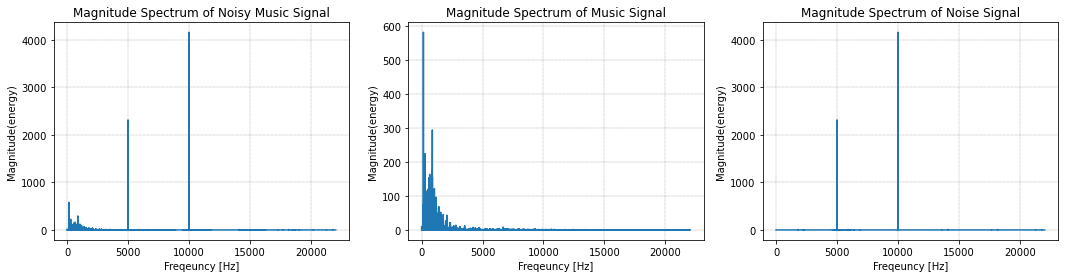

In [15]:
#Plotting all Magnitude Spectrums
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
axes = [ax1, ax2, ax3]

freqs = [freq1, freq2, freq3]
ffts = [noisy_music_fft, music_fft, noise_fft]
titles = ['Noisy Music', 'Music', 'Noise']

for i in range(0,len(axes)):
    axes[i].plot(cp.asnumpy(freqs[i]), cp.asnumpy(ffts[i]))
    axes[i].set_title("Magnitude Spectrum of {} Signal".format(titles[i]), size='12')
    axes[i].set_xlabel('Freqeuncy [Hz]')
    axes[i].set_ylabel("Magnitude(energy)")
    axes[i].grid(True, color='k', linestyle=':', linewidth=0.3)

From the plots above, we can see the various magnitude spectrum values and how they vary. We see that the noise have higher energy compared to the music signal. We will work more on this in a later notebook.

## Filters

Now that we have identified the frequency of the noisy signal, we will design a low pass filter that eliminates the unwanted frequencies, they are the 5KHz and 10KHz present in the noisy signal.

In [16]:
num_taps = 77 # Using odd number of taps(play with this and see the effect)
cut_off = 3500 # Our selected cutoff frequency, take note of 1KHz transition width
sample_rate = 44100 #Our signal sample rate of 44100Hz

# creating our low pass filter
h = cusignal.firwin(num_taps, cut_off, nyq=sample_rate/2)

We just designed our low pass FIR filter above !!!

This filter rejectes any frequency above 3.5KHz, our noisy signals are 5KHz and 10KHz, hence, they will be rejected. Take note of the 1KHz transition width we selected while designing the filter. Play with the number of taps and cut off frequency parameters above and see the results.

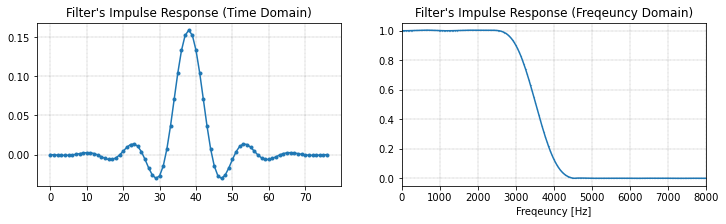

In [17]:
# calculating the frequency response
H = cp.abs(cp.fft.fft(h, 1024)) # take the 1024-point FFT and magnitude
H = cp.fft.fftshift(H) # make 0Hz in the center
w = cp.linspace(-sample_rate/2, sample_rate/2, len(H)) # x axis


#Plotting both time domain and freqeuncy domain of our low pass filter
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3))

ax1.plot(cp.asnumpy(h), '.-')
ax1.set_title("Filter's Impulse Response (Time Domain)", size=12)
ax1.grid(True, color='k', linestyle=':', linewidth=0.3)

ax2.plot(cp.asnumpy(w), cp.asnumpy(H),'.-', markersize=0.5)
ax2.set_xlabel('Freqeuncy [Hz]')
ax2.set_title("Filter's Impulse Response (Freqeuncy Domain)", size=12)
ax2.set_xlim(0, 8000)
ax2.grid(True, color='k', linestyle=':', linewidth=0.3)

As you can see in our filter impulse response frequency domain plot above, the cut off frequency we selected was 3.5KHz. 

Now we will pass our noisy music through the low pass filter `h` we just created above, this is an implementation process

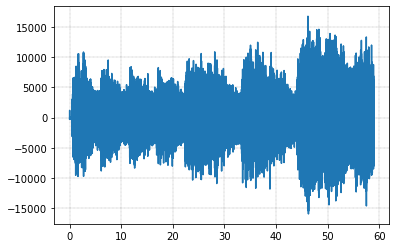

In [18]:
#Filtering our noisy music

filtered_output = cp.convolve(h, noisy_music) #Passing our noisy signal through the filter we designed

t = cp.linspace(0, (filtered_output.shape[0]/sample_rate), filtered_output.shape[0])

plt.plot(cp.asnumpy(t), cp.asnumpy(filtered_output))
plt.grid(True, color='k', linestyle=':', linewidth=0.3)

Next, we plot the magnitude spectrum of the filtered music. As a way of comparison, we will plot it side by side with the noisy music. This was, we can see the eliminated noise frequencies.

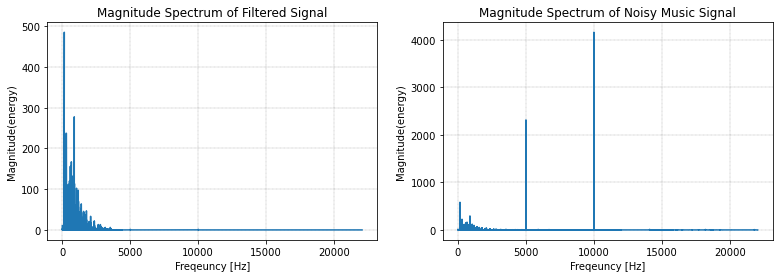

In [19]:
#Creating the freqeuncy axis of our filtered music plot
n = filtered_output.shape[0]
freq4 = (sample_rate/2)*cp.linspace(0,1,int(n//2))

#Computng the FFT of our filtered music
audio_fft = cp.fft.fft(filtered_output)
#We take the absolute value since we are only interested in the magnitude
audio_fft = (2/n)*abs(audio_fft[0:cp.size(freq4)])


#Plotting both 
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
axes = [ax1, ax2]

freqs = [freq4, freq1]
ffts = [audio_fft, noisy_music_fft]
titles = ['Filtered', 'Noisy Music']

for i in range(0,len(axes)):
    axes[i].plot(cp.asnumpy(freqs[i]), cp.asnumpy(ffts[i]))
    axes[i].set_title("Magnitude Spectrum of {} Signal".format(titles[i]), size='12')
    axes[i].set_xlabel('Freqeuncy [Hz]')
    axes[i].set_ylabel("Magnitude(energy)")
    axes[i].grid(True, color='k', linestyle=':', linewidth=0.3)

In [ ]:
# pip install wavio

In [ ]:
# Creating the .wav audio file
import wavio
wavio.write("cleaned_music.wav", cp.asnumpy(filtered_output), sample_rate, sampwidth=3)

In [ ]:
play_cleaned_music = Audio('cleaned_music.wav')
play_cleaned_music

We can see that the noise has been drastically reduced and almost eliminated. Our filter did the job it was meant to do.

## Spectogram

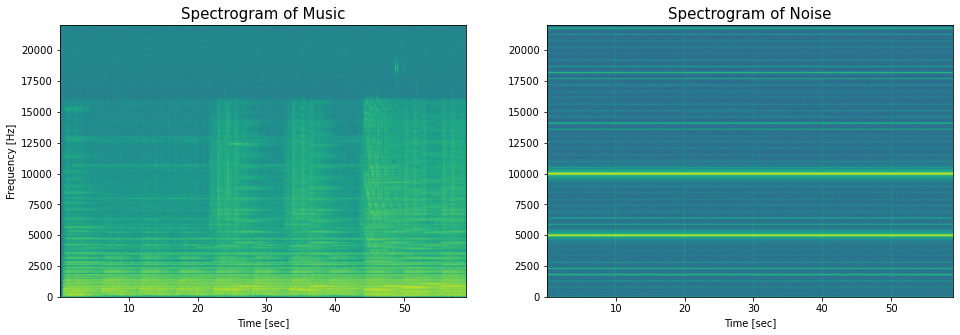

In [20]:
#Plotting both music and noise spectogram
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))

ax1.specgram(cp.asnumpy(music[:,1]), NFFT=2048, Fs=sample_rate, noverlap=1024)
ax1.set_title("Spectrogram of Music", size='15')
ax1.set_ylabel('Frequency [Hz]')
ax1.set_xlabel('Time [sec]')
              
ax2.specgram(cp.asnumpy(noise), NFFT=2048, Fs=sample_rate, noverlap=1024)
ax2.set_title("Spectrogram of Noise", size='15')
ax2.set_xlabel('Time [sec]');
# plt.colorbar(format='%+2.0f Mag')

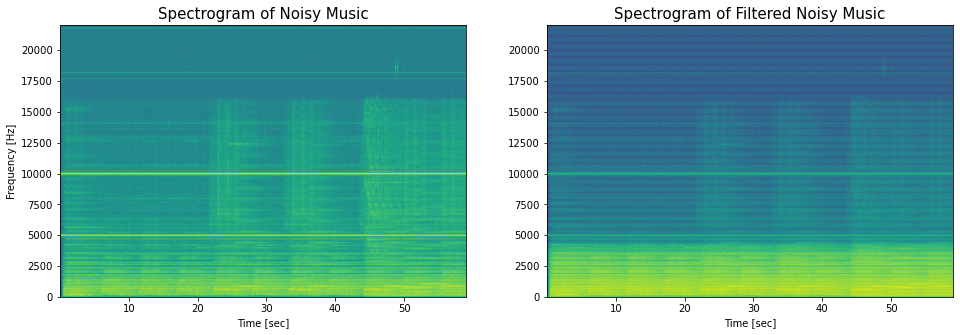

In [21]:
#Plotting both noisy music and filtered music spectogram
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))

ax1.specgram(cp.asnumpy(noisy_music), NFFT=2048, Fs=sample_rate, noverlap=1024)
ax1.set_title("Spectrogram of Noisy Music", size='15')
ax1.set_ylabel('Frequency [Hz]')
ax1.set_xlabel('Time [sec]')
              
ax2.specgram(cp.asnumpy(filtered_output), NFFT=2048, Fs=sample_rate, noverlap=1024)
ax2.set_title("Spectrogram of Filtered Noisy Music", size='15')
ax2.set_xlabel('Time [sec]');
# plt.colorbar(format='%+2.0f Mag')